# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [1]:
! git clone https://github.com/ds4e/linearModels

Cloning into 'linearModels'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 43 (delta 9), reused 5 (delta 5), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 3.60 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Make               976 non-null    object
 1   Make_Year          976 non-null    int64 
 2   Color              976 non-null    object
 3   Body_Type          976 non-null    object
 4   Mileage_Run        976 non-null    int64 
 5   No_of_Owners       976 non-null    object
 6   Seating_Capacity   976 non-null    int64 
 7   Fuel_Type          976 non-null    object
 8   Transmission       976 non-null    object
 9   Transmission_Type  976 non-null    object
 10  Price              976 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 84.0+ KB
None
           Make    Make_Year  Color  Body_Type   Mileage_Run No_of_Owners  \
count       976   976.000000    976        976    976.000000          976   
unique       16          NaN     15          5           NaN            3 

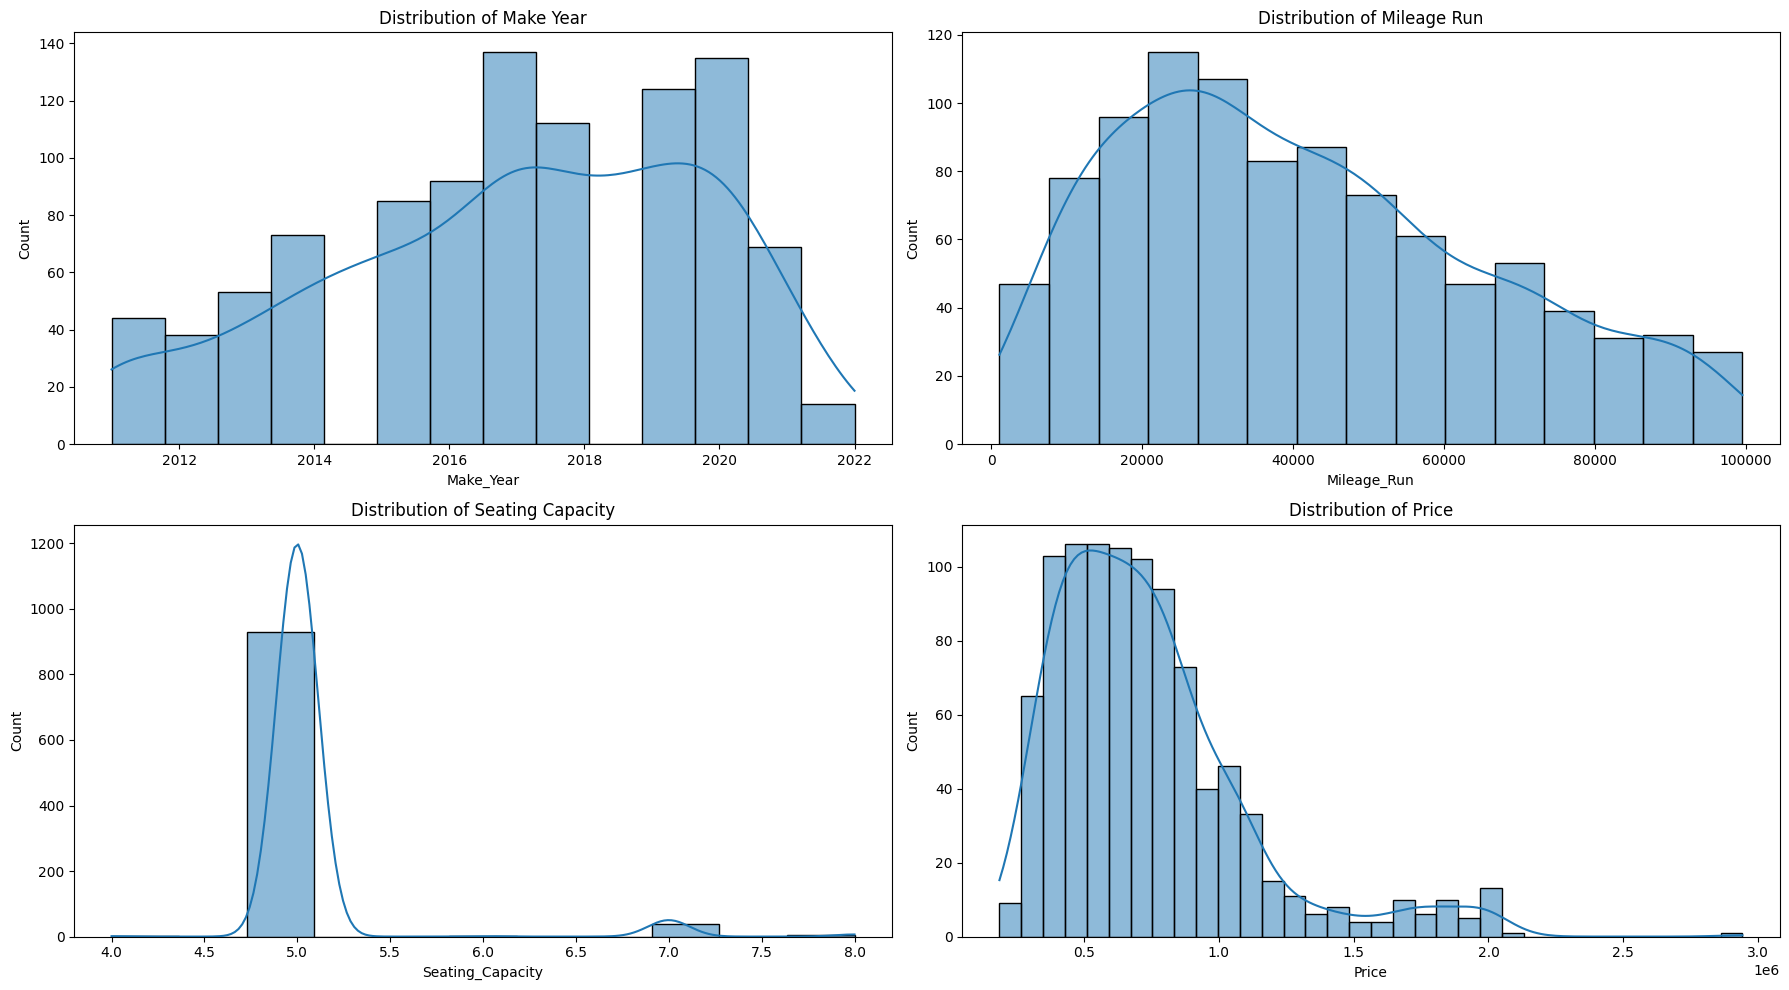

In [6]:
#1
file_path = '/content/linearModels/lab/data/cars_hw.csv'
cars_df = pd.read_csv(file_path)

# basic info
cars_df = cars_df.drop(columns=['Unnamed: 0'])
print(cars_df.info())
print(cars_df.describe(include='all'))
cars_df.head()

# some plotting
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
sns.histplot(cars_df['Make_Year'], kde=True)
plt.title('Distribution of Make Year')

plt.subplot(2, 2, 2)
sns.histplot(cars_df['Mileage_Run'], kde=True)
plt.title('Distribution of Mileage Run')

plt.subplot(2, 2, 3)
sns.histplot(cars_df['Seating_Capacity'], kde=True)
plt.title('Distribution of Seating Capacity')

plt.subplot(2, 2, 4)
sns.histplot(cars_df['Price'], kde=True)
plt.title('Distribution of Price')

plt.tight_layout()
plt.show()

In [7]:
#2
cars_df_encoded = pd.get_dummies(cars_df, columns=['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'], drop_first=True)
cars_df_encoded.head()

,Make_Year,Mileage_Run,No_of_Owners,Seating_Capacity,Price,Make_Datsun,Make_Ford,Make_Honda,Make_Hyundai,Make_Jeep,...,Body_Type_muv,Body_Type_sedan,Body_Type_suv,Fuel_Type_petrol,Fuel_Type_petrol+cng,Transmission_5-Speed,Transmission_6-Speed,Transmission_7-Speed,Transmission_CVT,Transmission_Type_Manual
0,2017,44611,1st,5,657000,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2016,20305,1st,5,682000,False,False,False,True,False,...,False,False,False,True,False,True,False,False,False,True
2,2019,29540,2nd,5,793000,False,False,True,False,False,...,False,False,True,True,False,True,False,False,False,True
3,2017,35680,1st,5,414000,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
4,2017,25126,1st,5,515000,False,False,False,True,False,...,False,False,False,True,False,True,False,False,False,True


In [8]:
#3
from sklearn.model_selection import train_test_split
X = cars_df_encoded.drop(columns='Price')
y = cars_df_encoded['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 780 samples
Test set size: 196 samples


In [12]:
#4
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
cars_df['No_of_Owners'] = cars_df['No_of_Owners'].replace({'1st': 1, '2nd': 2, '3rd': 3})
cars_df_encoded = pd.get_dummies(cars_df, columns=['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'], drop_first=True)

X = cars_df_encoded.drop(columns='Price')  # all but price (target)
y = cars_df_encoded['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R²: {train_r2}")
print(f"Test R²: {test_r2}")

Training RMSE: 142154.19343476923
Test RMSE: 143815.30276718995
Training R²: 0.8552247578997088
Test R²: 0.8196717007174028


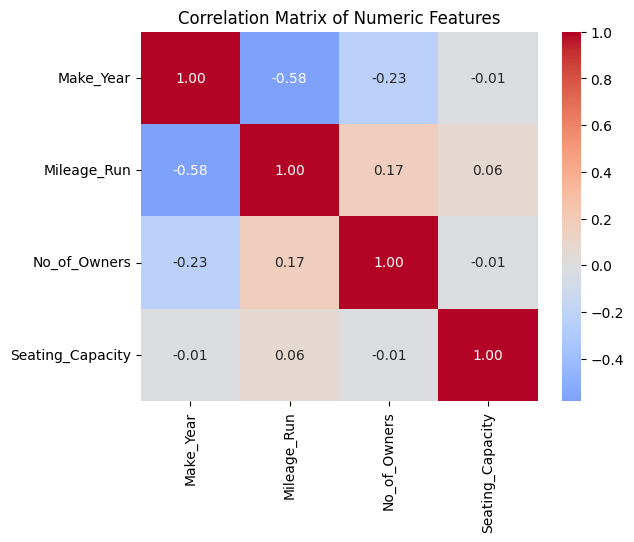

In [15]:
#5
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# numeric cols
numeric_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])
corr_matrix = np.corrcoef(X_numeric_scaled, rowvar=False)

#heat map
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', center=0, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [16]:
#6
X['Mileage_Seating_Interaction'] = X['Mileage_Run'] * X['Seating_Capacity']

X['Log_Mileage_Run'] = np.log1p(X['Mileage_Run'])  # log

X_complex = X.copy()

X_complex = X_complex[['Mileage_Run', 'Seating_Capacity', 'Mileage_Seating_Interaction', 'Log_Mileage_Run'] + [col for col in X.columns if col not in ['Mileage_Run', 'Seating_Capacity', 'Mileage_Seating_Interaction', 'Log_Mileage_Run']]]

# train/test
X_train_complex, X_test_complex, y_train, y_test = train_test_split(X_complex, y, test_size=0.2, random_state=42)
model_complex = LinearRegression()
model_complex.fit(X_train_complex, y_train)

y_train_pred_complex = model_complex.predict(X_train_complex)
y_test_pred_complex = model_complex.predict(X_test_complex)

train_rmse_complex = np.sqrt(mean_squared_error(y_train, y_train_pred_complex))
test_rmse_complex = np.sqrt(mean_squared_error(y_test, y_test_pred_complex))

train_r2_complex = r2_score(y_train, y_train_pred_complex)
test_r2_complex = r2_score(y_test, y_test_pred_complex)

#results
print(f"Training RMSE (Complex Model): {train_rmse_complex}")
print(f"Test RMSE (Complex Model): {test_rmse_complex}")
print(f"Training R² (Complex Model): {train_r2_complex}")
print(f"Test R² (Complex Model): {test_r2_complex}")

Training RMSE (Complex Model): 140977.0583150953
Test RMSE (Complex Model): 143324.8994100133
Training R² (Complex Model): 0.8576125091149538
Test R² (Complex Model): 0.8208994257851556


\#7
After cleaning the data and performing some basic EDA, I looked at which variables were categorical vs numerical. Applying one-hot encoding to categorical variables and making a simple model off that, I got pretty good results; the Test R² wasn't too much lower than the Training R², and both were relatively high for a simple model. Upon making an interaction term between mileage and seating capacity, doing a log transformation to reduce skewness in mileage, and generally making the model more flexible, I had a more complex model which rendered barely better results; the R² improved a tiny bit in each category, which I think still is a win, because at the end of the day, the model is better!